# TEAM 44 - kdd cyberattack (K09)

This is the second part of the first lab assignment of the course "Neural Networks and Intelligent Systems" at the National Technical University of Athens.

**Team 44** consists of **George Kyriakopoulos** (03118153) and **Serafeim Tzelepis** (03118849).

## Packages and imports

In [2]:
%pip install pip --upgrade
%pip install scikit-learn --upgrade
%pip install numpy --upgrade
%pip install matplotlib --upgrade
%pip install imbalanced-learn --upgrade
%pip install pandas --upgrade
%pip install tabulate --upgrade
%pip install seaborn --upgrade

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated pa

In [3]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

In [4]:
# to make this notebook's output stable across runs while preparing the lab
import dill
dill.load_session('notebook_env.db')

## Introduction and Overview

For this part we will use a Kaggle dataset, [kdd cyberattack](https://www.kaggle.com/datasets/slashtea/kdd-cyberattack).

This is the data set used for The Third International Knowledge Discovery and Data Mining Tools Competition, which was held in conjunction with KDD-99 The Fifth International Conference on Knowledge Discovery and Data Mining. The competition task was to build a network intrusion detector, a predictive model capable of distinguishing between bad connections, called intrusions or attacks, and good normal connections. This database contains a standard set of data to be audited, which includes a wide variety of intrusions simulated in a military network environment.

The dataset contains a total of [22 training attack types](http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types) (excluding the normal label), that fall into four main categories, DOS, R2L, U2R and probing, with an additional 14 types in the test data only. The dataset has 42 variables in total.

In [49]:
# get kddcup.data_10_percent.csv file
!wget -q http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz -P resources
!gunzip -f -q resources/kddcup.data_10_percent.gz
!mv resources/kddcup.data_10_percent resources/kddcup.data_10_percent.csv

# read data from kddcup.data_10_percent.csv file
df = pd.read_csv('resources/kddcup.data_10_percent.csv', header=None)

# print basic info about dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 42 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       494021 non-null  int64  
 1   1       494021 non-null  object 
 2   2       494021 non-null  object 
 3   3       494021 non-null  object 
 4   4       494021 non-null  int64  
 5   5       494021 non-null  int64  
 6   6       494021 non-null  int64  
 7   7       494021 non-null  int64  
 8   8       494021 non-null  int64  
 9   9       494021 non-null  int64  
 10  10      494021 non-null  int64  
 11  11      494021 non-null  int64  
 12  12      494021 non-null  int64  
 13  13      494021 non-null  int64  
 14  14      494021 non-null  int64  
 15  15      494021 non-null  int64  
 16  16      494021 non-null  int64  
 17  17      494021 non-null  int64  
 18  18      494021 non-null  int64  
 19  19      494021 non-null  int64  
 20  20      494021 non-null  int64  
 21  21      49

There was no needed transformation of the data, since it was already in a usable form.

There are 494021 samples and 41 features in the dataset. The types of the features are as follows:

* duration: continuous
* protocol_type: symbolic
* service: symbolic
* flag: symbolic
* src_bytes: continuous
* dst_bytes: continuous
* land: symbolic
* wrong_fragment: continuous
* urgent: continuous
* hot: continuous
* num_failed_logins: continuous
* logged_in: symbolic
* num_compromised: continuous
* root_shell: continuous
* su_attempted: continuous
* num_root: continuous
* num_file_creations: continuous
* num_shells: continuous
* num_access_files: continuous
* num_outbound_cmds: continuous
* is_host_login: symbolic
* is_guest_login: symbolic
* count: continuous
* srv_count: continuous
* serror_rate: continuous
* srv_serror_rate: continuous
* rerror_rate: continuous
* srv_rerror_rate: continuous
* same_srv_rate: continuous
* diff_srv_rate: continuous
* srv_diff_host_rate: continuous
* dst_host_count: continuous
* dst_host_srv_count: continuous
* dst_host_same_srv_rate: continuous
* dst_host_diff_srv_rate: continuous
* dst_host_same_src_port_rate: continuous
* dst_host_srv_diff_host_rate: continuous
* dst_host_serror_rate: continuous
* dst_host_srv_serror_rate: continuous
* dst_host_rerror_rate: continuous
* dst_host_srv_rerror_rate: continuous

All the symbolic features (7 of them) are not ordinal features.

There are no labels for the features and no row indexing.

The last column (42nd) is the label of the classes, which is the type of the attack or normal if the connection is not an attack.

In [51]:
# drop the constant features and print a suitable message
dropped = []

for col in df.columns:
    if len(df[col].unique()) == 1:
        dropped.append(col)
        df = df.drop(col, axis=1)

print(f"Dropped {len(dropped)} features, {dropped}.")

# slice the dataframe to split the features from the labels
labels_df = df.iloc[:, -1]
labels = labels_df.values.reshape(494021)
features_df = df.iloc[:, :-1]

# use cat.codes to convert categorical variables to numerical
features_df[1] = features_df[1].astype('category').cat.codes
features_df[2] = features_df[2].astype('category').cat.codes
features_df[3] = features_df[3].astype('category').cat.codes

features = features_df.values

# print info needed to answer the questions
print(f"Number of samples with missing values: {features_df.isnull().values.any(axis=1).sum()}")

print(f"Number of classes: {len(np.unique(labels))}")
print(f"Class distribution: \n")
print(tabulate(pd.DataFrame(labels_df.value_counts()/len(labels_df)).reset_index().values, headers=['Class', 'Ratio'], floatfmt=".6f"))
print(f"Highest class frequency ratio: {labels_df.value_counts().max()/labels_df.value_counts().min()}")

# keep only a random 10% sample of the data for faster processing
sfeatures, slabels = sklearn.utils.shuffle(features, labels, random_state=42, n_samples=49402)

Dropped 2 features, [19, 20].
Number of samples with missing values: 0
Number of classes: 23
Class distribution: 

Class                Ratio
----------------  --------
smurf.            0.568377
neptune.          0.216997
normal.           0.196911
back.             0.004459
satan.            0.003216
ipsweep.          0.002524
portsweep.        0.002105
warezclient.      0.002065
teardrop.         0.001982
pod.              0.000534
nmap.             0.000468
guess_passwd.     0.000107
buffer_overflow.  0.000061
land.             0.000043
warezmaster.      0.000040
imap.             0.000024
rootkit.          0.000020
loadmodule.       0.000018
ftp_write.        0.000016
multihop.         0.000014
phf.              0.000008
perl.             0.000006
spy.              0.000004
Highest class frequency ratio: 140395.0


There are no missing values on this dataset. All the samples have every feature filled.

There is a total of 23 classes, 22 attack types and 1 normal class. Their percentage in the dataset can be seen on the table above, with the highest being class smurf with 0.568377 of the samples and the lowest being spy with 0.000004 of the samples. This is class-imbalanced multi-class dataset, as the most frequent class is 140395 times more frequent than the least frequent class, which is higher than the 1.5 allowed.

## Preparation

In [52]:
# split the 10% data into train (56%) and test sets (44%)
X_train, X_test, y_train, y_test = train_test_split(sfeatures, slabels, test_size=0.44, random_state=42)

print(f"Number of samples and features of X_train data: {X_train.shape}")
print(f"Number of samples and features of X_test data: {X_test.shape}")

Number of samples and features of X_train data: (27665, 39)
Number of samples and features of X_test data: (21737, 39)


## Classification

### Out of the box

In [6]:
# classifiers
MLP = MLPClassifier()
SVM = SVC()

# dictionaries for results
names = {}
ootb_accuracy = {}
ootb_f1 = {}
ootb_accuracy_cv = {}
ootb_f1_cv = {}

# names of classifiers
names['MLP'] = 'Multi-Layer Perceptron'
names['SVM'] = 'Support Vector Machine'

# fit the classifiers
MLP.fit(X_train, y_train)
SVM.fit(X_train, y_train)

# predict
y_pred_MLP = MLP.predict(X_test)
y_pred_SVM = SVM.predict(X_test)

# accuracy
ootb_accuracy['MLP'] = accuracy_score(y_test, y_pred_MLP)
ootb_accuracy['SVM'] = accuracy_score(y_test, y_pred_SVM)

# f1 macro score
ootb_f1['MLP'] = f1_score(y_test, y_pred_MLP, average='macro')
ootb_f1['SVM'] = f1_score(y_test, y_pred_SVM, average='macro')

# 10-fold cross validation accuracy
ootb_accuracy_cv['MLP'] = cross_val_score(MLP, X_train, y_train, cv=10, scoring='accuracy').mean()
ootb_accuracy_cv['SVM'] = cross_val_score(SVM, X_train, y_train, cv=10, scoring='accuracy').mean()

# 10-fold cross validation f1 macro score
ootb_f1_cv['MLP'] = cross_val_score(MLP, X_train, y_train, cv=10, scoring='f1_macro').mean()
ootb_f1_cv['SVM'] = cross_val_score(SVM, X_train, y_train, cv=10, scoring='f1_macro').mean()

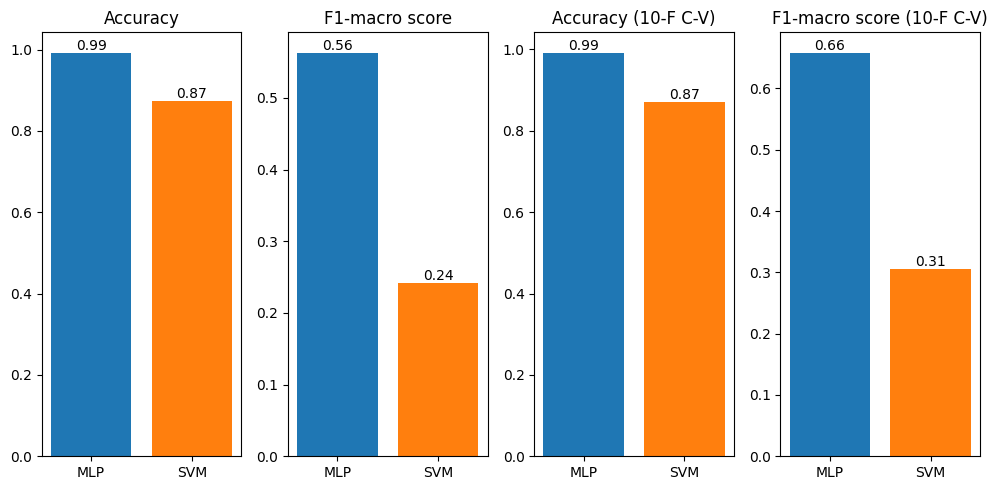

╭────────────────────────┬────────────┬──────────────────┬───────────────────────────────────────┬─────────────────────────────────────────────╮
│ Classifier             │   Accuracy │   F1-macro score │   Accuracy (10-Fold Cross-Validation) │   F1-macro score (10-Fold Cross-Validation) │
├────────────────────────┼────────────┼──────────────────┼───────────────────────────────────────┼─────────────────────────────────────────────┤
│ Multi-Layer Perceptron │       0.99 │             0.56 │                                  0.99 │                                        0.66 │
├────────────────────────┼────────────┼──────────────────┼───────────────────────────────────────┼─────────────────────────────────────────────┤
│ Support Vector Machine │       0.87 │             0.24 │                                  0.87 │                                        0.31 │
╰────────────────────────┴────────────┴──────────────────┴───────────────────────────────────────┴────────────────────────────────

In [57]:
color = ['tab:blue', 'tab:orange']

# bar plot accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.bar(range(len(ootb_accuracy)), list(ootb_accuracy.values()), align='center', color=color)
plt.xticks(range(len(ootb_accuracy)), list(ootb_accuracy.keys()))
plt.bar_label(plt.gca().containers[0], fmt='%.2f')
plt.title('Accuracy')

# bar plot f1 macro score
plt.subplot(1, 4, 2)
plt.bar(range(len(ootb_f1)), list(ootb_f1.values()), align='center', color=color)
plt.xticks(range(len(ootb_f1)), list(ootb_f1.keys()))
plt.bar_label(plt.gca().containers[0], fmt='%.2f')
plt.title('F1-macro score')

# bar plot cross validation accuracy
plt.subplot(1, 4, 3)
plt.bar(range(len(ootb_accuracy_cv)), list(ootb_accuracy_cv.values()), align='center', color=color)
plt.xticks(range(len(ootb_accuracy_cv)), list(ootb_accuracy_cv.keys()))
plt.bar_label(plt.gca().containers[0], fmt='%.2f')
plt.title('Accuracy (10-F C-V)')

# bar plot cross validation f1 macro score
plt.subplot(1, 4, 4)
plt.bar(range(len(ootb_f1_cv)), list(ootb_f1_cv.values()), align='center', color=color)
plt.xticks(range(len(ootb_f1_cv)), list(ootb_f1_cv.keys()))
plt.bar_label(plt.gca().containers[0], fmt='%.2f')
plt.title('F1-macro score (10-F C-V)')
plt.tight_layout()
plt.show()

# print table
headers = ["Classifier", "Accuracy", "F1-macro score", "Accuracy (10-Fold Cross-Validation)", "F1-macro score (10-Fold Cross-Validation)"]
data = [row for row in zip(names.values(), ootb_accuracy.values(), ootb_f1.values(), ootb_accuracy_cv.values(), ootb_f1_cv.values())]
print(tabulate(data, headers=headers, tablefmt='rounded_grid', floatfmt=".2f"))

### Optimization

#### Initializations and Feature Variance

In [55]:
# default transformers initialization
selector = VarianceThreshold()
standard = StandardScaler()
min_max = MinMaxScaler()
ros = RandomOverSampler()
rus = RandomUnderSampler()
pca = PCA()

# dictionaries to store results
optimized_accuracy_acc = {}
optimized_accuracy_f1 = {}
optimized_f1_acc = {}
optimized_f1_f1 = {}
train_time_acc = {}
train_time_f1 = {}
test_time_acc = {}
test_time_f1 = {}

In [56]:
# check variance to select threshold values
train_variance = X_train.var(axis=0)
print(f'- Train data feature variance: \n {train_variance}')
print(f'--------------------------------------------------------------------------------')
print(f'- Minimum, maximum, mean and median variance:')
print(f'{np.min(train_variance)}, {np.max(train_variance)}, {np.mean(train_variance)}, {np.median(train_variance)}')

- Train data feature variance: 
 [4.66133126e+05 3.32080292e-01 1.82342566e+02 5.02297415e+00
 5.01255590e+09 3.09553622e+07 0.00000000e+00 1.58743852e-02
 0.00000000e+00 5.75414824e-01 7.22882853e-05 1.26059862e-01
 7.12765943e-03 1.08428508e-04 0.00000000e+00 3.04857806e-02
 9.57710158e-03 2.89127009e-04 7.94805294e-04 1.11929380e-03
 4.54292528e+04 6.05355833e+04 1.43079105e-01 1.43298780e-01
 5.32920609e-02 5.34011004e-02 1.49110767e-01 6.46106655e-03
 2.03071234e-02 4.13789722e+03 1.11686046e+04 1.67430695e-01
 1.17936915e-02 2.31271452e-01 1.86855808e-03 1.43004457e-01
 1.43260146e-01 5.27225386e-02 5.25175823e-02]
--------------------------------------------------------------------------------
- Minimum, maximum, mean and median variance:
0.0, 5012555901.452746, 129335868.15207738, 0.05340110039452113


#### Multi-Layer Perceptron

In [10]:
# initialize pipeline and grid search for accuracy
pipe_acc = Pipeline(steps=[('selector', selector), ('scaler', standard), ('sampler', ros), ('mlp', MLP)], memory='tmp')
threshold_acc = [0, 0.05, 0.1, 0.2, 0.5, 1]
hidden_layer_sizes = [(10,), (30,), (50,), (70,), (90,)]
activation = ['identity', 'logistic', 'tanh', 'relu']
solver = ['lbfgs', 'sgd', 'adam']
alpha = [0.0001, 0.001, 0.01, 0.1]
learning_rate = ['constant', 'invscaling', 'adaptive']
max_iter = [100, 200, 300, 400, 500]

estimator_acc = HalvingRandomSearchCV(pipe_acc, dict(selector__threshold=threshold_acc, mlp__activation = activation, mlp__solver = solver, mlp__alpha = alpha, mlp__learning_rate = learning_rate, mlp__max_iter = max_iter, mlp__hidden_layer_sizes = hidden_layer_sizes), cv=10, scoring='accuracy', n_jobs=-1)
estimator_acc.fit(X_train, y_train)

# print top 9 results
results = pd.DataFrame(estimator_acc.cv_results_)
results = results.sort_values(by='mean_test_score', ascending=False)
results = results[['mean_test_score', 'params']]

for i in range(9):
    print(f"accuracy: {np.format_float_positional(results.iloc[i, 0], 4)}, threshold: {results.iloc[i, 1]["selector__threshold"]}, activation: {results.iloc[i, 1]["mlp__activation"]}, solver: {results.iloc[i, 1]["mlp__solver"]}, alpha: {results.iloc[i, 1]["mlp__alpha"]}, learning_rate: {results.iloc[i, 1]["mlp__learning_rate"]}, max_iter: {results.iloc[i, 1]["mlp__max_iter"]}, hidden_layer_sizes: {results.iloc[i, 1]["mlp__hidden_layer_sizes"]}")

/home/sertze/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sertze/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sertze/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sertze/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sertze/.local/lib/python3.10/site-packages

accuracy: 0.9980, threshold: 0, activation: relu, solver: adam, alpha: 0.001, learning_rate: adaptive, max_iter: 500, hidden_layer_sizes: (30,)
accuracy: 0.9979, threshold: 0, activation: tanh, solver: lbfgs, alpha: 0.1, learning_rate: invscaling, max_iter: 500, hidden_layer_sizes: (30,)
accuracy: 0.9978, threshold: 0, activation: relu, solver: adam, alpha: 0.001, learning_rate: adaptive, max_iter: 500, hidden_layer_sizes: (30,)
accuracy: 0.9978, threshold: 0, activation: tanh, solver: lbfgs, alpha: 0.1, learning_rate: invscaling, max_iter: 500, hidden_layer_sizes: (30,)
accuracy: 0.9970, threshold: 0, activation: tanh, solver: lbfgs, alpha: 0.001, learning_rate: invscaling, max_iter: 500, hidden_layer_sizes: (30,)
accuracy: 0.9967, threshold: 0, activation: relu, solver: adam, alpha: 0.001, learning_rate: adaptive, max_iter: 500, hidden_layer_sizes: (30,)
accuracy: 0.9959, threshold: 0, activation: relu, solver: sgd, alpha: 0.01, learning_rate: constant, max_iter: 100, hidden_layer_si

In [11]:
# initialize pipeline and grid search for f1-macro score
pipe_f1 = Pipeline(steps=[('selector', selector), ('scaler', standard), ('sampler', ros), ('mlp', MLP)], memory='tmp')
threshold_f1 = [0, 0.03, 0.05, 0.1, 0.2, 0.5, 1]
hidden_layer_sizes = [(10,), (30,), (50,), (60), (70,), (90,)]
activation = ['identity', 'logistic', 'tanh', 'relu']
solver = ['lbfgs', 'sgd', 'adam']
alpha = [0.0001, 0.001, 0.01, 0.1]
learning_rate = ['constant', 'invscaling', 'adaptive']
max_iter = [200, 300, 350, 400, 450]

estimator_f1 = HalvingRandomSearchCV(pipe_f1, dict(selector__threshold=threshold_f1, mlp__activation = activation, mlp__solver = solver, mlp__alpha = alpha, mlp__learning_rate = learning_rate, mlp__max_iter = max_iter, mlp__hidden_layer_sizes = hidden_layer_sizes), cv=10, scoring='f1_macro', n_jobs=-1)
estimator_f1.fit(X_train, y_train)

# print top 9 results
results = pd.DataFrame(estimator_f1.cv_results_)
results = results.sort_values(by='mean_test_score', ascending=False)
results = results[['mean_test_score', 'params']]

for i in range(9):
    print(f"f1-macro: {np.format_float_positional(results.iloc[i, 0], 4)}, threshold: {results.iloc[i, 1]["selector__threshold"]}, activation: {results.iloc[i, 1]["mlp__activation"]}, solver: {results.iloc[i, 1]["mlp__solver"]}, alpha: {results.iloc[i, 1]["mlp__alpha"]}, learning_rate: {results.iloc[i, 1]["mlp__learning_rate"]}, max_iter: {results.iloc[i, 1]["mlp__max_iter"]}, hidden_layer_sizes: {results.iloc[i, 1]["mlp__hidden_layer_sizes"]}")

/home/sertze/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sertze/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sertze/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sertze/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/sertze/.local/lib/python3.10/site-packages

{'selector__threshold': 0, 'mlp__solver': 'lbfgs', 'mlp__max_iter': 300, 'mlp__learning_rate': 'adaptive', 'mlp__hidden_layer_sizes': (90,), 'mlp__alpha': 0.01, 'mlp__activation': 'relu'}
0.9034428996462387
f1: 0.9151, threshold: 0, activation: relu, solver: lbfgs, alpha: 0.01, learning_rate: adaptive, max_iter: 300, hidden_layer_sizes: (90,)
f1: 0.9047, threshold: 0, activation: identity, solver: lbfgs, alpha: 0.001, learning_rate: constant, max_iter: 350, hidden_layer_sizes: 60
f1: 0.9034, threshold: 0, activation: relu, solver: lbfgs, alpha: 0.01, learning_rate: adaptive, max_iter: 300, hidden_layer_sizes: (90,)
f1: 0.9025, threshold: 0.03, activation: identity, solver: adam, alpha: 0.001, learning_rate: constant, max_iter: 200, hidden_layer_sizes: 60
f1: 0.9025, threshold: 0, activation: relu, solver: lbfgs, alpha: 0.01, learning_rate: adaptive, max_iter: 300, hidden_layer_sizes: (90,)
f1: 0.9025, threshold: 0.03, activation: identity, solver: adam, alpha: 0.001, learning_rate: inv

In [61]:
zipped = zip(["Accuracy", "F1-macro score"],
             [estimator_acc, estimator_f1],
             [train_time_acc, train_time_f1],
             [test_time_acc, test_time_f1],
             [optimized_accuracy_acc, optimized_accuracy_f1],
             [optimized_f1_acc, optimized_f1_f1])

for scoring, estimator, train_time, test_time, optimized_accuracy, optimized_f1 in zipped:
    # get fit and predict times on test data
    start = time.time()
    estimator.best_estimator_.fit(X_train, y_train)
    end = time.time()
    train_time['MLP'] = end - start

    start = time.time()
    y_preds = estimator.best_estimator_.predict(X_test)
    end = time.time()
    test_time['MLP'] = end - start
    
    # get accuracy and f1 macro score on test data
    optimized_accuracy['MLP'] = accuracy_score(y_test, y_preds)
    optimized_f1['MLP'] = f1_score(y_test, y_preds, average='macro')

    # print best estimator
    print(f"- Multi-Layer Perceptron model selection based on {scoring}")
    print(f"Best estimator: {estimator.best_estimator_.steps}")
    print(f"{scoring} (10-Fold Cross-Validation): {np.format_float_positional(estimator.best_score_, 2)}") 

    # print accuracy and f1 macro score
    print(f"Accuracy: {np.format_float_positional(optimized_accuracy['MLP'], 2)}")
    print(f"F1-macro score: {np.format_float_positional(optimized_f1['MLP'], 2)}")

    # print fit and predict times
    print(f"Time to fit: {np.format_float_positional(train_time['MLP'], 5)} sec")
    print(f"Time to predict: {np.format_float_positional(test_time['MLP'], 5)} sec")

    if estimator != estimator_f1:
        print(f"--------------------------------------------------------------------------------")

# after finding out that its the best estimator based on accuracy we store it for the confusion matrix
best_estimator = estimator_acc.best_estimator_

- Multi-Layer Perceptron model selection based on Accuracy
Best estimator: [('selector', VarianceThreshold(threshold=0)), ('standard', StandardScaler()), ('ros', RandomOverSampler()), ('SVM', SVC(C=1, gamma='auto', tol=0.01))]
Accuracy (10-Fold Cross-Validation): 1.
Accuracy: 1.
F1-macro score: 0.82
Time to fit: 17.20308 sec
Time to predict: 3.99038 sec
--------------------------------------------------------------------------------
- Multi-Layer Perceptron model selection based on F1-macro score
Best estimator: [('selector', VarianceThreshold(threshold=0.03)), ('standard', StandardScaler()), ('ros', RandomOverSampler()), ('SVM', SVC(C=100, tol=0.1))]
F1-macro score (10-Fold Cross-Validation): 0.84
Accuracy: 1.
F1-macro score: 0.7
Time to fit: 58.78367 sec
Time to predict: 30.44428 sec


#### Support Vector Machine

In [13]:
# initialize pipeline and grid search for accuracy
pipe_acc = Pipeline([('selector', selector), ('standard', standard), ('ros', ros), ('SVM', SVM)], memory='tmp')
threshold_acc = [0, 0.05, 0.1, 0.2, 0.5, 1]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
C = [0.1, 1, 10, 100]
tol = [0.0001, 0.001, 0.01, 0.1]
gamma = ['scale', 'auto']

estimator_acc = HalvingGridSearchCV(pipe_acc, dict(selector__threshold=threshold_acc, SVM__kernel = kernel, SVM__C = C, SVM__tol = tol, SVM__gamma = gamma), scoring='accuracy', n_jobs=-1, cv=10)
estimator_acc.fit(X_train, y_train)

# print top 9 results
results = pd.DataFrame(estimator_acc.cv_results_)
results = results.sort_values(by='mean_test_score', ascending=False)
results = results[['mean_test_score', 'params']]

for i in range(9):
    print(f"accuracy: {np.format_float_positional(results.iloc[i, 0], 4)}, threshold: {results.iloc[i, 1]["selector__threshold"]}, C: {results.iloc[i, 1]["SVM__C"]}, tol: {results.iloc[i, 1]["SVM__tol"]}, gamma: {results.iloc[i, 1]["SVM__gamma"]}, kernel: {results.iloc[i, 1]["SVM__kernel"]}")

accuracy: 0.9978, threshold: 0, C: 100, tol: 0.001, gamma: scale, kernel: rbf
accuracy: 0.9978, threshold: 0, C: 100, tol: 0.1, gamma: scale, kernel: rbf
accuracy: 0.9978, threshold: 0, C: 100, tol: 0.0001, gamma: scale, kernel: rbf
accuracy: 0.9978, threshold: 0, C: 100, tol: 0.01, gamma: scale, kernel: rbf
accuracy: 0.9977, threshold: 0, C: 1, tol: 0.01, gamma: auto, kernel: rbf
accuracy: 0.9977, threshold: 0, C: 1, tol: 0.001, gamma: auto, kernel: rbf
accuracy: 0.9974, threshold: 0.1, C: 100, tol: 0.1, gamma: auto, kernel: rbf
accuracy: 0.9974, threshold: 0.1, C: 100, tol: 0.0001, gamma: auto, kernel: rbf
accuracy: 0.9974, threshold: 0, C: 1, tol: 0.001, gamma: auto, kernel: rbf


In [15]:
# initialize pipeline and grid search for f1-macro score
pipe_f1 = Pipeline([('selector', selector), ('standard', standard), ('ros', ros), ('SVM', SVM)], memory='tmp')
threshold_f1 = [0, 0.03, 0.05, 0.1, 0.2, 0.5, 1]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
C = [0.1, 1, 10, 100]
tol = [0.0001, 0.001, 0.01, 0.1]
gamma = ['scale', 'auto']

estimator_f1 = HalvingGridSearchCV(pipe_f1, dict(selector__threshold=threshold_f1, SVM__kernel = kernel, SVM__C = C, SVM__tol = tol, SVM__gamma = gamma), scoring='f1_macro', n_jobs=-1, cv=10)
estimator_f1.fit(X_train, y_train)

# print top 9 results
results = pd.DataFrame(estimator_f1.cv_results_)
results = results.sort_values(by='mean_test_score', ascending=False)
results = results[['mean_test_score', 'params']]

for i in range(9):
    print(f"f1-macro: {np.format_float_positional(results.iloc[i, 0], 4)}, threshold: {results.iloc[i, 1]["selector__threshold"]}, C: {results.iloc[i, 1]["SVM__C"]}, tol: {results.iloc[i, 1]["SVM__tol"]}, gamma: {results.iloc[i, 1]["SVM__gamma"]}, kernel: {results.iloc[i, 1]["SVM__kernel"]}")

      iter  n_resources  mean_fit_time  std_fit_time  mean_score_time  \
0        0          300       0.047598      0.004062         0.001746   
1        0          300       0.042566      0.011862         0.002210   
2        0          300       0.040675      0.014787         0.001698   
3        0          300       0.035519      0.009236         0.001852   
4        0          300       0.041100      0.007770         0.001598   
...    ...          ...            ...           ...              ...   
1336     4        24300      43.308252      8.197770         1.224716   
1337     4        24300      71.527903     12.777673         2.744380   
1338     4        24300      69.553400     12.290215         2.771445   
1339     4        24300      65.110883      8.974061         2.728245   
1340     4        24300      56.049488      7.832306         1.990742   

      std_score_time param_SVM__C param_SVM__gamma param_SVM__kernel  \
0           0.000217          0.1            scale 

In [60]:
zipped = zip(["Accuracy", "F1-macro score"],
             [estimator_acc, estimator_f1],
             [train_time_acc, train_time_f1],
             [test_time_acc, test_time_f1],
             [optimized_accuracy_acc, optimized_accuracy_f1],
             [optimized_f1_acc, optimized_f1_f1])

for scoring, estimator, train_time, test_time, optimized_accuracy, optimized_f1 in zipped:
    # get fit and predict times on test data
    start = time.time()
    estimator.best_estimator_.fit(X_train, y_train)
    end = time.time()
    train_time['SVM'] = end - start

    start = time.time()
    y_preds = estimator.best_estimator_.predict(X_test)
    end = time.time()
    test_time['SVM'] = end - start
    
    # get accuracy and f1 macro score on test data
    optimized_accuracy['SVM'] = accuracy_score(y_test, y_preds)
    optimized_f1['SVM'] = f1_score(y_test, y_preds, average='macro')

    # print best estimator
    print(f"- Support Vector Machine model selection based on {scoring}")
    print(f"Best estimator: {estimator.best_estimator_.steps}")
    print(f"{scoring} (10-Fold Cross-Validation): {np.format_float_positional(estimator.best_score_, 2)}")

    # print accuracy and f1 score
    print(f"Accuracy: {np.format_float_positional(optimized_accuracy['SVM'], 2)}")
    print(f"F1-macro score: {np.format_float_positional(optimized_f1['SVM'], 2)}")

    # print fit and predict times
    print(f"Time to fit: {np.format_float_positional(train_time['SVM'], 5)} sec")
    print(f"Time to predict: {np.format_float_positional(test_time['SVM'], 5)} sec")

    if estimator != estimator_f1:
        print(f"--------------------------------------------------------------------------------")

# after finding out that its the worst estimator based on accuracy we keep it for the confusion matrix
worst_estimator = estimator_f1.best_estimator_

- Support Vector Machine model selection based on Accuracy
Best estimator: [('selector', VarianceThreshold(threshold=0)), ('standard', StandardScaler()), ('ros', RandomOverSampler()), ('SVM', SVC(C=1, gamma='auto', tol=0.01))]
Accuracy (10-Fold Cross-Validation): 1.
Accuracy: 1.
F1-macro score: 0.82
Time to fit: 17.77822 sec
Time to predict: 4.25614 sec
--------------------------------------------------------------------------------
- Support Vector Machine model selection based on F1-macro score
Best estimator: [('selector', VarianceThreshold(threshold=0.03)), ('standard', StandardScaler()), ('ros', RandomOverSampler()), ('SVM', SVC(C=100, tol=0.1))]
F1-macro score (10-Fold Cross-Validation): 0.84
Accuracy: 1.
F1-macro score: 0.7
Time to fit: 57.16332 sec
Time to predict: 31.20834 sec


## Results and Conclusion

### Tables

In [62]:
# dictionaries to hold the percentage differences between the optimized and default models
diff_acc_acc = {}
diff_f1_acc = {}

for model in optimized_accuracy_acc:
    diff_acc_acc[model] = (optimized_accuracy_acc[model] - ootb_accuracy[model]) / ootb_accuracy[model] * 100
    diff_f1_acc[model] = (optimized_f1_acc[model] - ootb_f1[model]) / ootb_f1[model] * 100

# print the table
headers_acc = ["Best Classifier by Accuracy", "Accuracy", "F1-macro score", "Optimized vs OOTB for Accuracy (%)", "Optimized vs OOTB for F1-macro score (%)", "Train time (sec)", "Test time (sec)"]
data_acc = [row for row in zip(names.values(), optimized_accuracy_acc.values(), optimized_f1_acc.values(), diff_acc_acc.values(), diff_f1_acc.values(), train_time_acc.values(), test_time_acc.values())]
print(tabulate(data_acc, headers=headers_acc, tablefmt='rounded_grid', floatfmt=("", ".2f", ".2f", ".2f", ".2f", ".5f", ".5f")))

╭───────────────────────────────┬────────────┬──────────────────┬──────────────────────────────────────┬────────────────────────────────────────────┬────────────────────┬───────────────────╮
│ Best Classifier by Accuracy   │   Accuracy │   F1-macro score │   Optimized vs OOTB for Accuracy (%) │   Optimized vs OOTB for F1-macro score (%) │   Train time (sec) │   Test time (sec) │
├───────────────────────────────┼────────────┼──────────────────┼──────────────────────────────────────┼────────────────────────────────────────────┼────────────────────┼───────────────────┤
│ Multi-Layer Perceptron        │       1.00 │             0.82 │                                 0.42 │                                      44.83 │           17.20308 │           3.99038 │
├───────────────────────────────┼────────────┼──────────────────┼──────────────────────────────────────┼────────────────────────────────────────────┼────────────────────┼───────────────────┤
│ Support Vector Machine        │       1.00 

In [63]:
# dictionaries to hold the percentage differences between the optimized and default models
diff_acc_f1 = {}
diff_f1_f1 = {}

for model in optimized_accuracy_f1:
    diff_acc_f1[model] = (optimized_accuracy_f1[model] - ootb_accuracy[model]) / ootb_accuracy[model] * 100
    diff_f1_f1[model] = (optimized_f1_f1[model] - ootb_f1[model]) / ootb_f1[model] * 100

# print the table
headers_f1= ["Best Classifier by F1-macro score", "Accuracy", "F1-macro score", "Optimized vs OOTB for Accuracy (%)", "Optimized vs OOTB for F1-macro score (%)", "Train time (sec)", "Test time (sec)"]
data_f1 = [row for row in zip(names.values(), optimized_accuracy_f1.values(), optimized_f1_f1.values(), diff_acc_f1.values(), diff_f1_f1.values(), train_time_f1.values(), test_time_f1.values())]
print(tabulate(data_f1, headers=headers_f1, tablefmt='rounded_grid', floatfmt=("", ".2f", ".2f", ".2f", ".2f", ".5f", ".5f")))

╭─────────────────────────────────────┬────────────┬──────────────────┬──────────────────────────────────────┬────────────────────────────────────────────┬────────────────────┬───────────────────╮
│ Best Classifier by F1-macro score   │   Accuracy │   F1-macro score │   Optimized vs OOTB for Accuracy (%) │   Optimized vs OOTB for F1-macro score (%) │   Train time (sec) │   Test time (sec) │
├─────────────────────────────────────┼────────────┼──────────────────┼──────────────────────────────────────┼────────────────────────────────────────────┼────────────────────┼───────────────────┤
│ Multi-Layer Perceptron              │       1.00 │             0.70 │                                 0.43 │                                      23.77 │           58.78367 │          30.44428 │
├─────────────────────────────────────┼────────────┼──────────────────┼──────────────────────────────────────┼────────────────────────────────────────────┼────────────────────┼───────────────────┤
│ Support Vecto

### Bar Charts

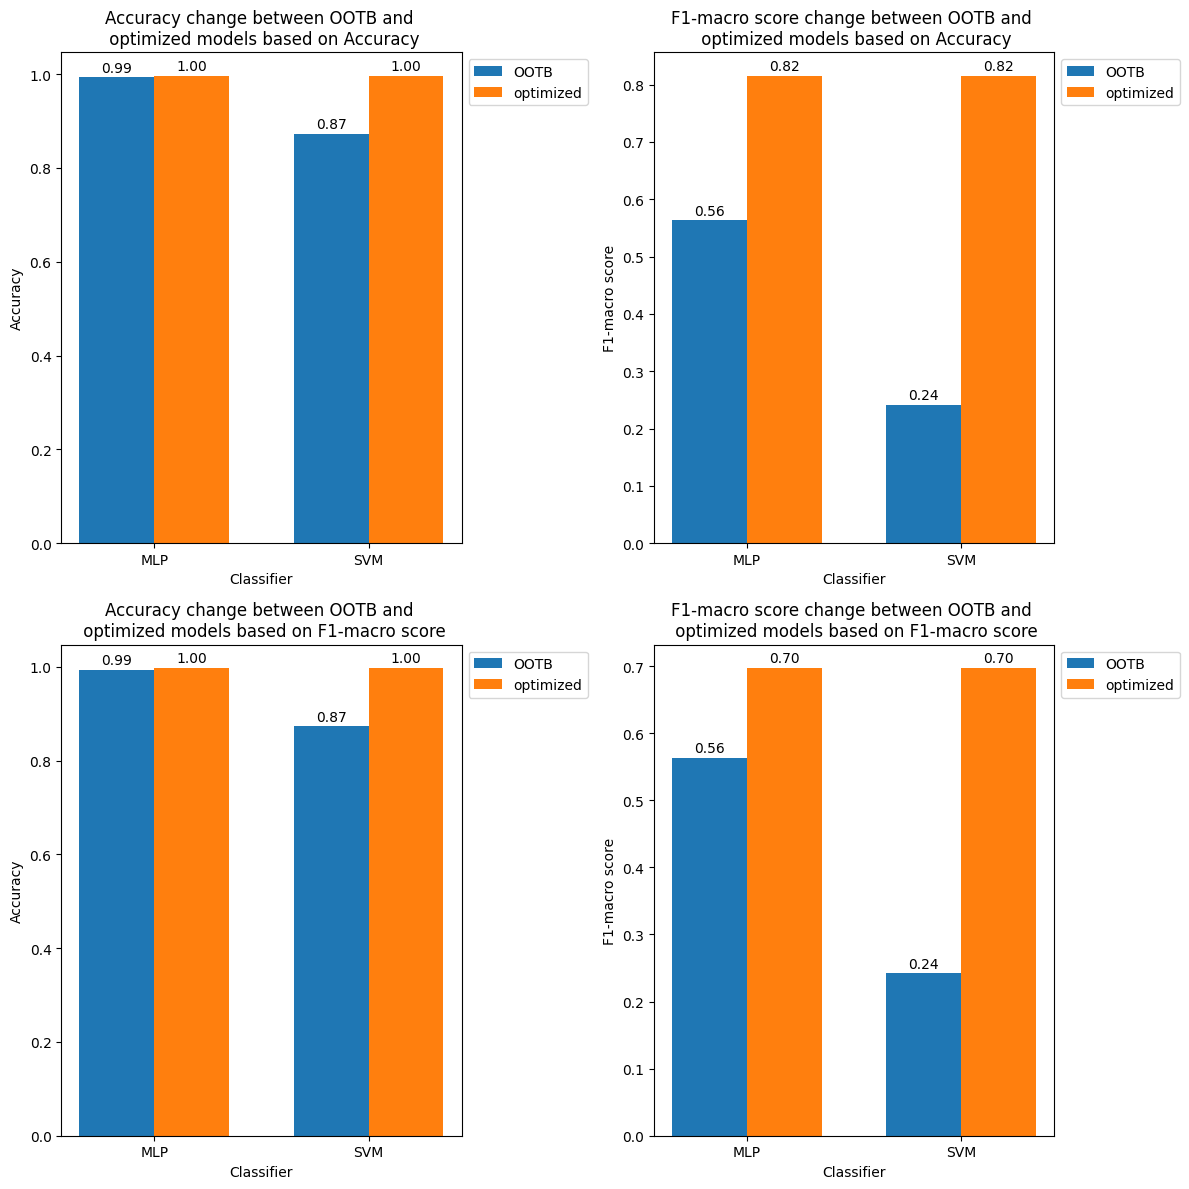

In [64]:
# print bar charts for the changes in accuracy and f1 score based on accuracy and f1 score
zipped = zip([(0, 0), (0, 1), (1, 0), (1, 1)], 
             [ootb_accuracy, ootb_f1, ootb_accuracy, ootb_f1],
             [optimized_accuracy_acc, optimized_f1_acc, optimized_accuracy_f1, optimized_f1_f1],
             ["Accuracy", "F1-macro score", "Accuracy", "F1-macro score"],
             ["Accuracy", "Accuracy", "F1-macro score", "F1-macro score"])

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
x = np.arange(len(names))
width = 0.35

for index, ootb, optimized, scoring, base in zipped:
    rects1 = ax[index].bar(x - width/2, ootb.values(), width, label='OOTB')
    rects2 = ax[index].bar(x + width/2, optimized.values(), width, label='optimized')
    ax[index].set_ylabel(scoring)
    ax[index].set_xlabel("Classifier")
    ax[index].set_title(f"{scoring} change between OOTB and \n optimized models based on {base}")
    ax[index].set_xticks(x, names.keys())
    ax[index].legend(bbox_to_anchor=(1, 1))
    ax[index].bar_label(rects1, padding=2, fmt='%.2f')
    ax[index].bar_label(rects2, padding=2, fmt='%.2f')

fig.tight_layout()
plt.show()

### Confusion Matrices

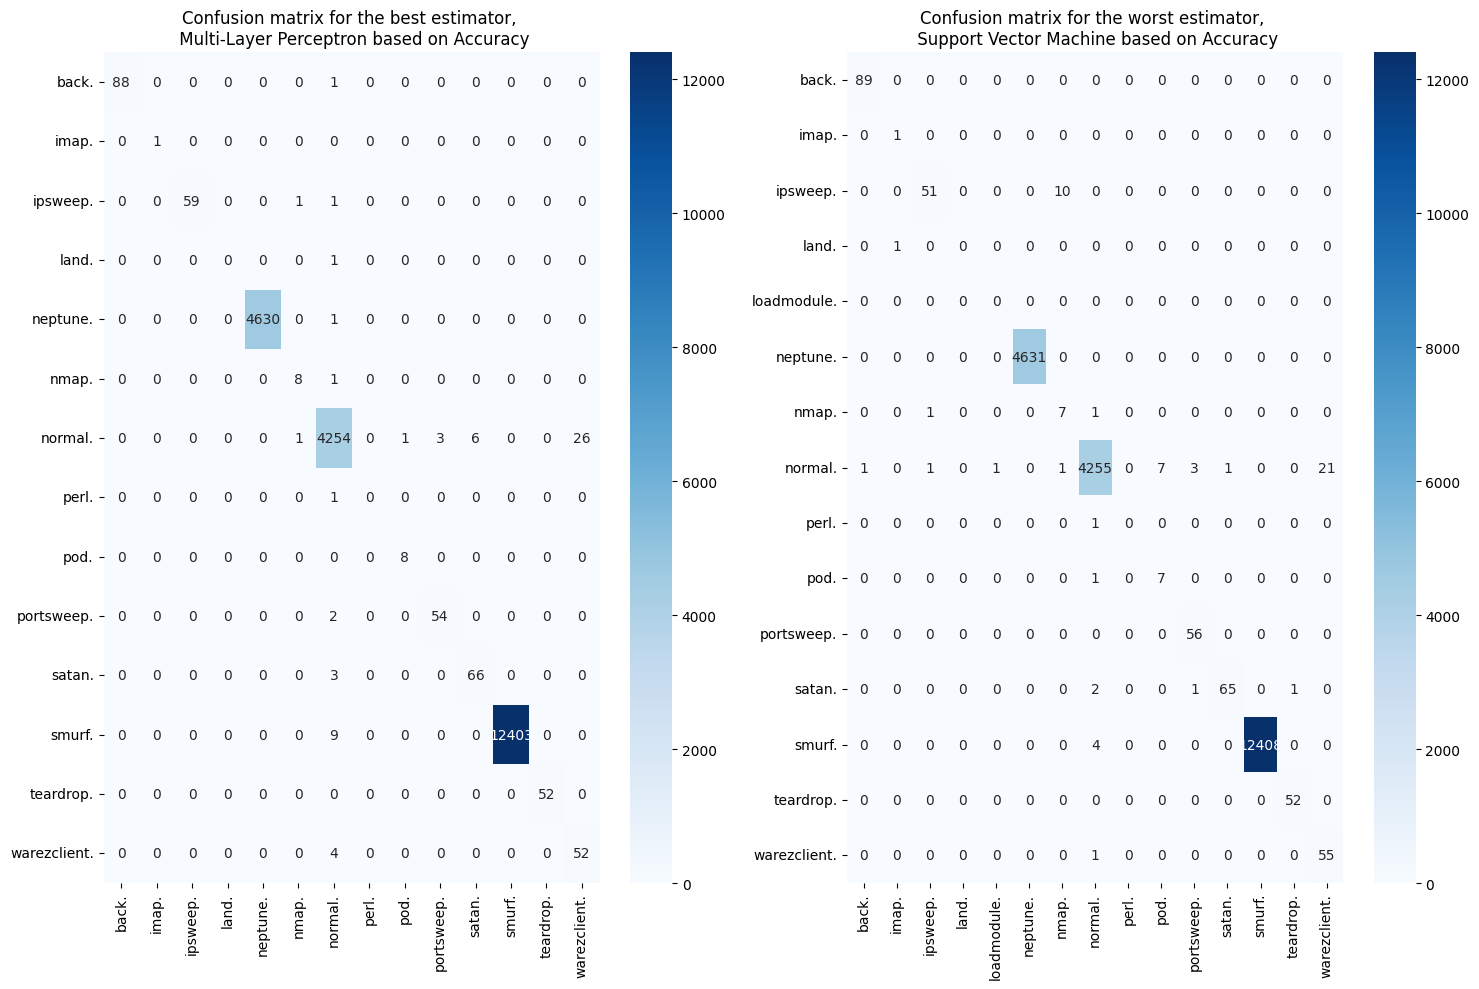

In [88]:
# print the confusion matrix for the best and worst model based on acurracy
zipped = zip([0, 1],
             [best_estimator, worst_estimator],
             ['best', 'worst'],
             ['MLP', 'SVM'])

fig, ax = plt.subplots(1, 2, figsize=(15, 10))

for index, estimator, kind, classifier in zipped:
    y_pred = estimator.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)

    class_names = np.sort(np.unique(np.concatenate((np.unique(y_test), np.unique(y_pred)))))
    labels = np.asarray(["{0:0.0f}".format(value) for value in cf_matrix.flatten()]).reshape(cf_matrix.shape[0],cf_matrix.shape[1])
    sns.heatmap(cf_matrix, annot=labels, fmt="", ax=ax[index], cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    ax[index].set_title(f"Confusion matrix for the {kind} estimator, \n {names[classifier]} based on Accuracy")

fig.tight_layout()
plt.show()